TODO:
- many qbits in circuit after target
- removing qArith for qVarArith after testing
- ensure we have the right answer at the end
- how is best to do multicontrol not (MCX). Should we do all in one MCX operation or separate it out? Which is less noisy?
- recycling the carry bit (adder paper). Could we use the same carry bit for all additions in the circuit? Uncompute carry after each one. Noisiness vs bit-saving.


In [26]:
from qiskit import *
from qiskit import QuantumRegister
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, IBMQ
from qiskit import providers
from qiskit.providers.aer import AerSimulator
from qiskit.tools.monitor import job_monitor

import matplotlib as mpl
import random
import pylatexenc
import numpy as np
import pandas as pd
from pandas import *
import copy
import os



In [41]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q")

ibmqfactory.load_account:WARNING:2024-04-04 12:25:38,212: Credentials are already in use. The existing account in the session will be replaced.


KeyboardInterrupt: 

# Quantum Circuit Class

In [28]:
##
##  A class to wrap the qiskit QuantumCircuit
##    It can allocate registers in sequence, which is very useful
##
class QC:
    def __init__(self, genBarriers=True):
        self.regNum = 0
        self.genBarriers = genBarriers
        self.qcx = QuantumCircuit()
        self.falseBit = self.addReg('false')
        self.trueBit  = self.addReg('true')
        self.qcx.x(self.trueBit)
        
    def getQuantumCircuit(self):
        return self.qcx

    def get_name(self, prefix=""):
        name = prefix+"_"+str(self.regNum)
        self.regNum+=1
        return name        
    
    def addReg(self, prefix="t"):
        name = self.get_name(prefix)
        result = QuantumRegister(1, name)
        self.qcx.add_register(result)
        return result

##
##  Measure the specified qubit onto a new classical bit
##     returns:  the classical register
##
    def mbit(self, qbit):
        result = ClassicalRegister(1, "m"+qbit.name)
        self.qcx.add_register(result)
        self.qcx.measure(qbit, result)
        return result

##
##  Put in barriers, or not, as dicitated by self.genBarriers
##
    def barrier(self):
        if self.genBarriers:
            self.qcx.barrier()
##
##  Emulate locally
##
    def em(self, shots=512):
        # em = Aer.get_backend("qasm_simulator")
        em = Aer.get_backend('aer_simulator_matrix_product_state')
        # job = execute(self.qcx, em, shots=shots)
        job = execute(self.qcx, em, shots=shots)
        hist = job.result().get_counts()
        return hist
    
##
## ToDo:  pick the method according to the number of qubits
## NB:   the usual simulator was ibmq_qasm_simulator by default
##    but we're using the one better suited to our purposes
##    Possiblities for method:
##        ibmq_qasm_simulator
##        simulator_mps
##
##
    def bem(self, shots=512, method='simulator_mps'):
        provider = IBMQ.get_provider(hub='ibm-q')
        real_device = provider.get_backend("simulator_mps")
        print('Status:')
        print('  Operational: ', real_device.status().operational)
        print('  Pending jobs:', real_device.status().pending_jobs)
        print('  Status message:', real_device.status().status_msg)
        job = execute(self.qcx, real_device, shots=shots)
        job_monitor(job, interval=2)
        res = job.result()
        return res.get_counts()
    
    def sv(self):
        svs = BasicAer.get_backend("statevector_simulator")
        job = execute(self.qcx, svs)
        ket = job.result().get_statevector()
        return ket
    
    
##
## Idea: split from here below into another decorator class
##
    
    def genOutput(self, reg, name):
        reg = reg if reg else self.addReg(name)
        return reg
    
    def qand(self, bit1, bit2, output=None):
        output = self.genOutput(output, "and")
        self.barrier()
        self.qcx.ccx(bit1, bit2, output)
        self.barrier()
        return output


    def qor(self, bit1, bit2, output=None):
        output = self.genOutput(output, "or")
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.qcx.ccx(bit1, bit2, output)
        self.barrier()
        return output
    
    def qxor(self, bit1, bit2, output=None):
        output = self.genOutput(output, "xor")
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.barrier()
        return output
##
##  While we don't need this method for completeness,
##     it can perform a 3-way xor without generating a
##     temporary, intermediate result, thus saving qubits
##
    def qxor3(self, bit1, bit2, bit3, name="xor3", output=None):
        output = self.genOutput(output, name)
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.qcx.cx(bit3, output)
        self.barrier()
        return output

    def qnot(self, bit, output=None):
        output = self.genOutput(output, "not")
        self.barrier()
        self.qcx.x(bit)
        self.qcx.cx(bit, output)
        self.qcx.x(bit)
        self.barrier()
        return output

    def qnand(self, bit1, bit2, output=None):
        output = self.genOutput(output, "nand")
        self.barrier()
        self.qcx.ccx(bit1, bit2, output)
        self.qcx.x(output)
        self.barrier()
        return output
    
    def same(self, bit1, bit2, output=None):
        output = self.genOutput(output, "same")
        self.barrier()
        self.qcx.x(output)
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.barrier()
        return output
        

###
### A more qulever carry computation, requiring no intermediate results
###   If exactly two bits are true, the output is flipped once, making it True
##    If all three are true, the output flips 3 times, making it True
##    If exactly one bit is true, no flipping occurs
##
    def quarry(self, bit1, bit2, bit3, output=None):
        output = self.genOutput(output, "quarry")
        self.barrier()
        self.qcx.ccx(bit1, bit2, output)
        self.qcx.ccx(bit2, bit3, output)
        self.qcx.ccx(bit1, bit3, output)
        self.barrier()
        return output
    
    
    def draw(self, output='mpl'):
        return self.qcx.draw(output=output)

# Quantum Arithmetic Class

In [42]:
##
##  Create integers and sums for the supplied quantum circuit
##    Throughout, a value is represented as a list of quantum registers,
##      least-significant-bit-first
##
class QVarArith:
    def __init__(self, qc):
        self.qc = qc
        self.ONE   = self.qint(1, "one")

    def numBits(self, val):
        if val == 0:
            return 1
        ans = int(np.log2(val))+1
        #print("For val " + str(val) + " " + str(ans) + " bits")
        return ans
##
##  Create the supplied value on the quantum circuit
##
    def qint(self, val, name=None, width=None):
        if not width:
            width = self.numBits(val)
        if not name:
            name = "qi("+str(val)+")"
        bitVal = []
        a = 1 #this would be the eventual separation point if we want to separate qint into defining width and values
        for i in range(width):
            t = self.qc.addReg(name)
            if val & a:
                self.qc.getQuantumCircuit().x(t)
            a = a << 1
            bitVal.append(t)
        return bitVal
    
#this is so our shadow registers for qvar can have defined length w/out defined value
    def qtemp(self,val,name=None):
        width = self.numBits(val)
        if not name:
            name = "qtempshad("+str(val)+")"
        bitVal = []
        for i in range(width):
            t = self.qc.addReg(name)
            bitVal.append(t)
        return bitVal
##
##  cin -- carry in
##  ba - one bit of input
##  bb -- other bit of input
##  returns the sum and carry bits
##  Note:  this is correct but chews up many temporary qubits
##
    def onebit(self, cin, ba, bb):
        ##
        ##  Using a 3-way :-) to save on qubits
        ##
        s = self.qc.qxor3(cin, ba, bb, name="add")
        ##
        ##  https://en.wikipedia.org/wiki/Adder_(electronics)#Full_adder
        ##  ba bb   +   cin (ba xor bb)
        # cout = self.qc.qor(self.qc.qand(ba,bb), self.qc.qand(cin,self.qc.qxor(ba,bb)))
        ##  Not using the above formuala, correct though it be
        ##    It generates 3 intermediate results, but the line below generates none
        ##
        cout = self.qc.quarry(cin, ba, bb)
        return s, cout
    
    def onebitshort(self, cin, ba, output=None):
        output = self.qc.genOutput(output, "quarry")
        s = self.qc.qxor(cin, ba)
        
        self.qc.getQuantumCircuit().ccx(cin, ba, output)
        return s, output
##
##  add the two inputs, returning the result
##
##  NB:  There is an opportunity to save one qubit here
##     The onebit call always generates both the sum s and the carry out, 
##        received as carry.  The carry is needed in the middle but not for
##        the very last onebit call
##     Making onebit aware of this would make the code ugly, I think [ RKC ]
##     Perhaps better would be to compute the sum and carry separately
##        and avoid the carry the last time. The onebit method is really just
##        those two calls, anyway, so this wouldn't be so hard.
##
    def add(self, val1, val2, width = 10):
        if len(val1) > len(val2):
            return self.add(val2, val1, width)
        ans   = []
        carry = self.qc.falseBit
        for i in range(len(val2)):
            if i<len(val1):
                s, carry = self.onebit(carry, val1[i], val2[i])
                ans.append(s)
            else:
                ##only need to add val2 and the carry at this point
                s, carry = self.onebitshort(carry, val2[i])
                ans.append(s)
        while len(ans) < width:
            ans.append(carry)
            carry = self.qc.addReg('pad')
        return ans
    
    def onescomp(self, val):
        self.qc.barrier()
        width = len(val)
        ans = []
        for i in range(width):
            ans.append(self.qc.qnot(val[i]))
        self.qc.barrier()
        return ans
    
    def compBits(self, val1, val2):
        self.qc.barrier()
        width = len(val1)
        while len(val1) < len(val2):
            val1.append(self.qc.falseBit)
        while len(val2) < len(val1):
            val2.append(self.qc.falseBit)
        ans = []
        for i in range(width):
            ans.append(self.qc.same(val1[i],val2[i]))
        self.qc.barrier()
        return ans
    
    def allOnes(self,val,output=None):
        self.qc.barrier()
        if not output:
            output = self.qc.genOutput(output, "allOne")
        self.qc.getQuantumCircuit().mcx(val,output)
        self.qc.barrier()
        return output

    def qompare(self, val1, val2):
        return self.allOnes(self.compBits(val1,val2))
                
    def neg(self, val): 
        return self.add(self.onescomp(val), self.ONE, len(val))
    
    def measure(self, val):
        width = len(val)
        result = []
        for i in range(width):
            b = self.qc.mbit(val[i])
            result.append(b)
        return result
    
    

In [47]:
##
## Test comparisons
##
qc = QC()
qi = QVarArith(qc)
qc.mbit(qi.qompare(qi.qint(5),qi.qint(6)))
qc.mbit(qi.qompare(qi.qint(1000),qi.qint(7)))
qc.em()

{'0 0': 512}

Quantum Arithmetic Example 

In [31]:
##
## 32 bit addition problem
##
qc = QC()
qi = QVarArith(qc)

ans = qi.qint(0)
for i in range(1,10):
    n = qi.qint(i)
    ans = qi.add(ans,n)
m = qi.measure(ans)
#qc.draw()
#qc.em(shots=16)

# Subset Sum Class

In [62]:
class QSubsetSum:
    
    def __init__(self, values, target, qc=None):
        if not qc:
            self.qc = QC()
        else:
            self.qc = qc
        self.values = values
        self.target = target
        # print(self.target)
    #move tester outside class
        
    
    
    def run(self,  test=False, sorted = True, partial = True, variable=True, width=None):
        if sorted:
            self.values.sort()
        if not width: #this allows us to do operations on a fixed bit length
            widthOfSum = int(np.log2(sum(self.values)))+1
        else:
            widthOfSum = width #placeholder: width = log2(sum) -- code this
        fixedWidthofSum = 32
        self.qi = QVarArith(self.qc)
        if variable:
            qintwidth = None
        else:
            qintwidth = widthOfSum
        
        self.x = []
        for i in range(len(self.values)): #creates x register
            r = self.qc.addReg(prefix = "x")
            self.x.append(r)
            ##
            ##  go ahead and call for the superposition of all
            ##   possible x values
            ##
            self.qc.getQuantumCircuit().h(r)
        # print(self.x)
        ##
        ##  sorted and unsorted versions
        ##
        ##  Create the running sum of integers in my (unsorted) set
        ##  ans maintains the running sum, and is returned at thend
        ##  By "sum" we mean that each integer in the set is either added
        ##    into the sum, or not, depending on the x control register
        ##  
        ##  ans starts out as a new register, all 0
        ##
        ans = self.qi.qint(0, name = "sum")
        
        if partial:
            totsum = 0
        else:
            totsum = int(sum(self.values))
        for i, s in enumerate(self.values): #stores integers as quantum registers
            r = self.qi.qint(s, width=qintwidth)
            ctrl = self.x[i]
            if partial:
                totsum += self.values[i]
            # print(partialSum)
            ##make qtemp function that allocates result reg as big as s
            shadow = self.qi.qtemp(s, name = "shd")
            # print(len(shadow))
            for a in range(len(shadow)):
                self.qc.getQuantumCircuit().ccx(ctrl, r[a], shadow[a]) #
            ans = self.qi.add(ans, shadow, self.qi.numBits(totsum)) ##added one to account for sign bit
            # ans = self.qi.add(ans, shadow, self.bigSum)
            # print("ans", ans)
        targ = self.qi.qint(self.target, name = "target", width=len(ans))
        # targ = self.qi.neg(targ)
        # print("targ", targ)
        # subtraction = self.qi.add(ans, targ, self.qi.numBits(totsum)+1) ##added one to account for sign bit
        result = self.qi.qompare(targ, ans)
        self.qi.measure(ans)
        self.qi.qc.mbit(result)
        # print(self.qc.regNum)
        if test == True:
            gateSum=0
            gates = self.qc.getQuantumCircuit().count_ops()
            for key, value in gates.items():
                if key not in ['barrier', 'measure']:
                    gateSum += value

        
            # print(gateSum)
            return self.qc.regNum, gateSum
            # return self.qc.regNum 
        return ans
    

    
    ##
    ## variable: use variable length addition, if false used fixed
    ## this is identical to run execept it returns the # of registers instead of the subtraction result.
    # def testRun(self, sorted = True, partial = True, variable=True, width=None):
    #     if sorted:
    #         self.values.sort()
    #     #widthOfSum = int(np.log2(sum(self.values)))+1 #placeholder: width = log2(sum) -- code this
    #     if not width: #this allows us to do operations on a fixed bit length
    #         widthOfSum = int(np.log2(sum(self.values)))+1
    #     else:
    #         widthOfSum = width #placeholder: width = log2(sum) -- code this
    #         variable = False
    #     self.qi = QVarArith(self.qc)
    #     if variable:
    #         qintwidth = None
    #     else:
    #         qintwidth = widthOfSum
        
    #     self.x = []
    #     for i in range(len(self.values)): #creates x register
    #         r = self.qc.addReg(prefix = "x")
    #         self.x.append(r)
    #         self.qc.getQuantumCircuit().h(r)
    #     ans = self.qi.qint(0, name = "sum")
        
    #     if partial:
    #         totsum = 0
    #     else:
    #         totsum = int(sum(self.values))

    #     for i, s in enumerate(self.values): #stores integers as quantum registers
    #         r = self.qi.qint(s, width=qintwidth)
    #         ctrl = self.x[i]
    #         if partial:
    #             totsum += self.values[i]
    #         shadow = self.qi.qtemp(s, name = "shd")
    #         for a in range(len(shadow)):
    #             self.qc.getQuantumCircuit().ccx(ctrl, r[a], shadow[a]) #
    #         ans = self.qi.add(ans, shadow, self.qi.numBits(totsum)+1)
            
    #     targ = self.qi.qint(self.target, name = "target", width=len(ans))
    #     targ = self.qi.neg(targ)
    #     subtraction = self.qi.add(ans, targ, self.qi.numBits(totsum)+1)
    #     self.qi.measure(subtraction)

        
        


# SUBTRACTION RESULT TESTING

In [65]:
s = [2,9,26,7,12]
# s = [2,3] 
# s=[2,9] #target = 5 works
# s=[2,3], target = 5 does not work
# s=[2,9], target = 11 does not work, some values need an additional sign bit

qc = QC()
target = 3
qsub = QSubsetSum(s, target, qc=qc)

# qc, test = tester(2)
# print(test)
qsub.run(variable=True)
# too big for now
# qc.draw('mpl')
res = qc.em()
print(res)

def twosToBinary(binary_str):
    binary_str = binary_str.replace(" ", "")
    is_negative = binary_str[0] == '1'
    if is_negative:
            inverted_bits = ''.join('1' if bit == '0' else '0' for bit in binary_str[1:])
            binary_str = bin(int(inverted_bits, 2) + 1)[2:]
    decimal_value = int(binary_str, 2)
    if is_negative:
        decimal_value = -decimal_value
    return decimal_value

# print(res.keys())

newdict = {}
newdict['Value'] = 'Counts'
for key in res.keys():
    newkey = twosToBinary(key)
    newdict[newkey]=[res[key]]
df = pd.DataFrame.from_dict(newdict)
df = df.transpose()
df = df.rename(columns={0: ''})
print(df)
# print(res)

{'0 0 0 1 1 0 0': 10, '0 1 0 0 1 0 1': 12, '0 1 0 1 1 0 0': 13, '0 0 0 1 1 1 0': 10, '0 0 1 0 0 1 1': 8, '0 0 1 0 0 1 0': 15, '0 1 0 1 0 0 0': 15, '0 1 1 0 0 0 1': 12, '0 1 0 0 0 0 1': 26, '0 0 1 0 0 0 0': 18, '0 0 0 1 0 0 1': 38, '0 1 0 1 1 0 1': 22, '0 0 0 1 0 1 1': 11, '0 0 1 1 0 1 0': 15, '0 0 0 0 0 1 0': 19, '0 1 1 1 0 0 0': 19, '0 1 1 0 1 1 0': 15, '0 1 0 0 0 1 1': 37, '0 0 1 1 1 0 0': 27, '0 0 1 0 1 1 1': 17, '0 1 0 1 1 1 1': 33, '0 0 0 0 0 0 0': 15, '0 1 0 0 1 1 0': 20, '0 0 1 0 1 0 1': 31, '0 0 1 1 1 1 0': 15, '0 0 0 0 1 1 1': 24, '0 1 0 1 0 1 0': 15}
             
Value  Counts
12         10
37         12
44         13
14         10
19          8
18         15
40         15
49         12
33         26
16         18
9          38
45         22
11         11
26         15
2          19
56         19
54         15
35         37
28         27
23         17
47         33
0          15
38         20
21         31
30         15
7          24
42         15


In [ ]:
qc.draw()

X Why are we getting negative outputs?

-Why do we need to feed in an existing QC?

-How to get the target subset if exists?

# Qubit Usage Testing

In [34]:
def tester(numVals, maxVal=None, width=None):
        
        if not maxVal:
            maxVal = 64
        randomlist = []
        for i in range(int(numVals)):
            n = random.randint(1,maxVal)
            randomlist.append(n)
        target = random.randint(1,sum(randomlist))
        
        print("number list: "+str(randomlist)+ "|  target: "+str(target))
        qsub1 = QSubsetSum(copy.deepcopy(randomlist), target)
        ans = qsub1.run(True, True, True, True) #varArith with sorted values and partial sum
        qsub2 = QSubsetSum(copy.deepcopy(randomlist), target)
        ans2 = qsub2.run(True, False, True, True) #varArith with unsorted values and partial sum
        qsub3 = QSubsetSum(copy.deepcopy(randomlist), target)
        ans3 = qsub3.run(True, False, False, True) #varArith with unsorted values and total sum
        qsub4 = QSubsetSum(copy.deepcopy(randomlist), target)
        ans4 = qsub4.run(True, False, False, False, width) #fixedArith with sorted values and partial sum
        print(ans)
        return ans, ans2, ans3, ans4

In [39]:
d = {'sorted,partial,varArith':[], 'unsorted,partial,varArith':[], 'unsorted,bigSum,varArith':[], 'fixedArith':[]}
gatedf = pd.DataFrame(data=d)
qubitdf = pd.DataFrame(data=d)

#loop over all numvals of tester

#number of values to check: [5,10,15]?
#maxVal values to check: [64, 128, 256]?
#number of runs for each data point: 50? 100? 250?

test = tester(5, 256, 32)
qubitdf.loc[len(df.index)] = [test[0][0], test[1][0],test[2][0], test[3][0]]
gatedf.loc[len(df.index)] = [test[0][1], test[1][1],test[2][1], test[3][1]]
# for i in range(100):
#     test = tester(30, 256)
    
#     df.loc[len(df.index)] = [test[0], test[1],test[2], test[3]]
display(qubitdf)
display(gatedf)

gatedf.loc[len(df.index)] = df.mean()
qubitdf.loc[len(df.index)] = df.mean()
# os.makedirs('tests', exist_ok=True)
# os.makedirs('gateTests', exist_ok=True) 
# gatedf.to_csv('gateTests/30vals256max.csv')
# qubitdf.to_csv('tests/30vals256max.csv')


number list: [230, 87, 238, 96, 164]|  target: 333
(245, 437)


,"sorted,partial,varArith","unsorted,partial,varArith","unsorted,bigSum,varArith",fixedArith
6,245.0,252.0,258.0,380.0


,"sorted,partial,varArith","unsorted,partial,varArith","unsorted,bigSum,varArith",fixedArith
6,437.0,446.0,455.0,455.0


# TESTING LOOP FOR QUBIT COUNTS

In [68]:
d = {'sorted,partial,varArith':[], 'unsorted,partial,varArith':[], 'unsorted,bigSum,varArith':[], 'fixed32bit':[]}

for num in range(5, 101, 5):
    #64 max
    gatedf = pd.DataFrame(data=d)
    qubitdf = pd.DataFrame(data=d)
    for i in range(100):
        test = tester(num, 64, 32)
        qubitdf.loc[len(gatedf.index)] = [test[0][0], test[1][0],test[2][0], test[3][0]]
        gatedf.loc[len(qubitdf.index)] = [test[0][1], test[1][1],test[2][1], test[3][1]]
    gatedf.loc[len(gatedf.index)] = gatedf.mean()
    qubitdf.loc[len(qubitdf.index)] = qubitdf.mean()
    os.makedirs('tests', exist_ok=True)
    os.makedirs('gateTests', exist_ok=True) 
    qubitdf.to_csv('tests/qubit'+str(num)+'vals64max.csv')
    gatedf.to_csv('gateTests/gate'+str(num)+'vals64max.csv')

    #128 max
    gatedf = pd.DataFrame(data=d)
    qubitdf = pd.DataFrame(data=d)
    for i in range(100):
        test = tester(num, 128, 32)
        qubitdf.loc[len(qubitdf.index)] = [test[0][0], test[1][0],test[2][0], test[3][0]]
        gatedf.loc[len(gatedf.index)] = [test[0][1], test[1][1],test[2][1], test[3][1]]
    gatedf.loc[len(qubitdf.index)] = gatedf.mean()
    qubitdf.loc[len(gatedf.index)] = qubitdf.mean()
    os.makedirs('tests', exist_ok=True)
    os.makedirs('gateTests', exist_ok=True) 
    qubitdf.to_csv('tests/qubit'+str(num)+'vals128max.csv')
    gatedf.to_csv('gateTests/gate'+str(num)+'vals128max.csv')

    #256 max
    gatedf = pd.DataFrame(data=d)
    qubitdf = pd.DataFrame(data=d)
    for i in range(100):
        test = tester(num, 256, 32)
        qubitdf.loc[len(qubitdf.index)] = [test[0][0], test[1][0],test[2][0], test[3][0]]
        gatedf.loc[len(gatedf.index)] = [test[0][1], test[1][1],test[2][1], test[3][1]]
    gatedf.loc[len(gatedf.index)] = gatedf.mean()
    qubitdf.loc[len(qubitdf.index)] = qubitdf.mean()
    os.makedirs('tests', exist_ok=True)
    os.makedirs('gateTests', exist_ok=True) 
    qubitdf.to_csv('tests/qubit'+str(num)+'vals256max.csv')
    gatedf.to_csv('gateTests/gate'+str(num)+'vals256max.csv')


    


number list: [5, 15, 39, 61, 18]|  target: 100
(128, 214)
number list: [9, 9, 38, 62, 43]|  target: 70
(135, 224)
number list: [17, 31, 49, 46, 24]|  target: 124
(143, 239)
number list: [24, 46, 62, 23, 14]|  target: 136
(137, 228)
number list: [27, 46, 21, 5, 39]|  target: 33
(131, 217)
number list: [6, 18, 10, 25, 34]|  target: 25
(121, 198)
number list: [34, 59, 48, 54, 35]|  target: 223
(156, 262)
number list: [40, 32, 46, 26, 9]|  target: 36
(141, 229)
number list: [64, 40, 47, 19, 26]|  target: 74
(149, 246)
number list: [2, 9, 52, 36, 63]|  target: 146
(126, 205)
number list: [32, 63, 14, 15, 3]|  target: 75
(119, 200)
number list: [53, 6, 12, 47, 38]|  target: 153
(131, 218)
number list: [53, 26, 2, 61, 44]|  target: 23
(132, 218)
number list: [44, 8, 32, 1, 23]|  target: 20
(116, 186)
number list: [40, 39, 64, 30, 58]|  target: 37
(154, 254)
number list: [19, 11, 40, 53, 23]|  target: 40
(135, 223)
number list: [48, 15, 27, 30, 44]|  target: 163
(139, 232)
number list: [44, 23

KeyboardInterrupt: 

# PLOTTING QUBIT COUNT RESULTS

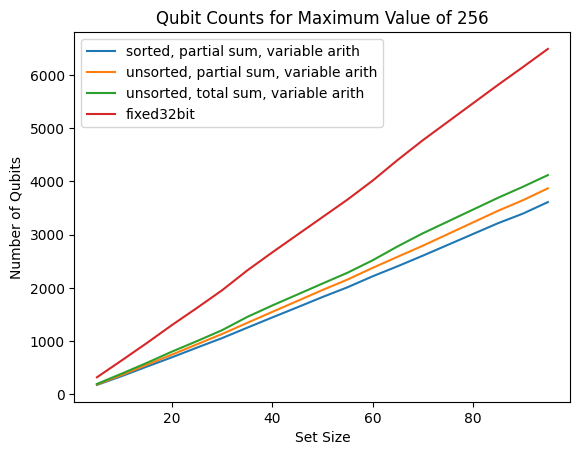

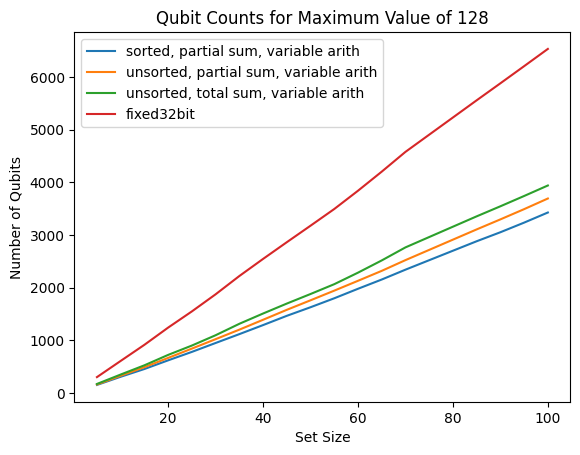

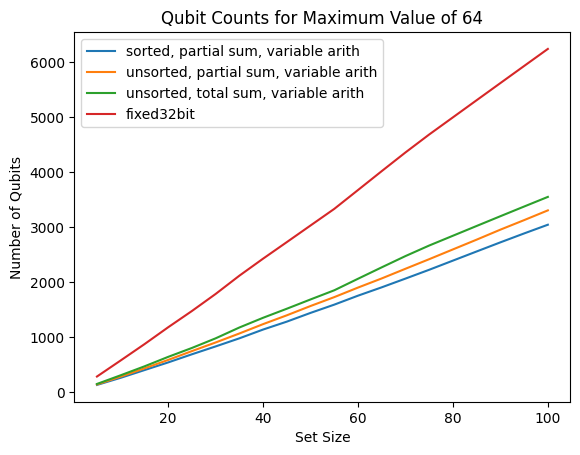

In [74]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
import re

# Function to list all relevant CSV files in the directory
def list_csv_files(directory):
    return [f for f in os.listdir(directory) if f.endswith('max.csv')]

# Function to parse filename and extract the values and max number
def parse_filename(filename):
    parts = filename.split('vals')[0], filename.split('max.csv')[0].split('vals')[-1]
    pattern = r'\d+'
    
    # Find all matches of the pattern in the input string
    match = re.findall(pattern, parts[0])
    match = int(match[0])
    return int(match), int(parts[1])  # Return vals, max as integers
# Function to parse filename and extract the values and max number for the new format "gate#val#max.csv"
# def parse_filename(filename):
#     base_name = filename.rstrip('.csv')  # Remove the '.csv' extension
#     parts = base_name.split('gate')[-1].split('#')
#     print(parts)
#     val, max_val = int(parts[1]), int(parts[2])  # Extract val and max values as integers
#     return val, max_val


# Function to group files by their max value
def group_files_by_max(files):
    groups = {}
    for file in files:
        _, max_val = parse_filename(file)
        if max_val not in groups:
            groups[max_val] = [file]
        else:
            groups[max_val].append(file)
    return groups


# Function to extract the last line of each file, excluding the first column, and create a numpy array
def create_numpy_array_for_group(files, directory):
    data = []
    for file in files:
        vals, _ = parse_filename(file)
        with open(os.path.join(directory, file), 'r') as csvfile:
            for last_line in csvfile:
                pass
            # Exclude the first column ([1:]) from each CSV's last line
            data.append([vals] + list(map(float, last_line.strip().split(',')[1:])))
    data = np.array(data)
    data = data[data[:, 0].argsort()]  # Sort by vals
    return data


# Function to plot the data from numpy arrays, with separate plots for each max group and labeled columns
def plot_data(groups, directory):
    # Define column labels according to the specified mapping
    column_labels = [
        "sorted, partial sum, variable arith",
        "unsorted, partial sum, variable arith",
        "unsorted, total sum, variable arith",
        "fixed32bit"
    ]
    
    for max_val, files in groups.items():
        plt.figure()  # Create a new figure for each max group
        data = create_numpy_array_for_group(files, directory)
        for i in range(1, data.shape[1]):  # Skip the first column as it's vals
            # Use the column index (i-1) to get the appropriate label from column_labels list
            label = column_labels[i-1] if i-1 < len(column_labels) else f'Column {i}'
            plt.plot(data[:, 0], data[:, i], label=label)
        plt.xlabel('Set Size')
        plt.ylabel('Number of Qubits')
        plt.title(f'Qubit Counts for Maximum Value of {max_val}')
        plt.legend()
        plt.show()



# Main function to orchestrate the operations
def main(directory):
    files = list_csv_files(directory)
    grouped_files = group_files_by_max(files)
    plot_data(grouped_files, directory)

# Note: Uncomment the line below and specify the directory path to run the script
main('tests')

# This code is structured to be easily understandable and maintainable, following the steps outlined in the approach.
